In [144]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import numpy as np
import plotnine as p9
pd.options.display.max_columns= None


from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Raleway']


In [78]:
data = pd.read_csv('barkbeetle_dataset.csv')

In [79]:
data.head()

,REVUFBADR,Jahr,ZR,Eigentumsgruppe,Zugang,Abgang,ETP_mean,FF1_mean,FF2_mean,FFB_mean,GRV_mean,KWK_mean,KWU_mean,RF0_mean,RGK_mean,RRK_mean,RRU_mean,SD0_mean,TM0_mean,TN0_mean,TX0_mean,area_nse,area_nsne,area_se,area_sne,centroid_xcoord,centroid_ycoord,county_name,district_name
0,2501,2007,06 Juni,SW,5.0,0.0,110.063631,2.973737,2.187542,2.314478,116.104377,-37.537037,-43.130978,69.536366,150.442419,72.526601,66.932660,222.087200,18.961279,12.705051,24.916160,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,Bautzen,Elsterheide
1,2501,2007,08 August,SW,12.0,12.0,96.605054,2.509764,1.842424,2.053872,93.217507,-43.587545,-48.396294,70.830302,133.832676,53.017506,48.208754,219.601339,18.506060,11.786532,24.279797,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,Bautzen,Elsterheide
2,2501,2007,10 Oktober-Dezember,SW,2.0,0.0,20.636252,3.778900,2.786419,2.681594,17.732323,25.473737,20.524242,84.794391,32.643995,46.109988,41.160494,67.778001,4.503592,1.476655,7.364197,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,Bautzen,Elsterheide
3,2501,2008,04 April,SW,1.0,0.0,56.318853,2.989899,2.194276,2.314478,56.411445,18.691584,11.635016,76.055556,92.474747,75.010443,67.953875,122.327283,8.478114,3.410774,13.134343,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,Bautzen,Elsterheide
4,2501,2008,06 Juni,SW,2.0,0.0,120.191235,2.705051,2.015488,2.162963,124.427938,-60.720203,-64.704710,63.186198,168.642427,59.471045,55.486532,269.523253,18.144107,10.505051,24.718181,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,Bautzen,Elsterheide


In [80]:
timeframe_dict = {
    '01 Januar-März': '-03-31',
    '04 April': '-04-30',
    '05 Mai': '-05-31',
    '06 Juni': '-06-30',
    '07 Juli': '-07-31',
    '08 August': '-08-31',
    '09 September': '-09-30',
    '10 Oktober-Dezember': '-12-31'
    }
             
     
data['timestamp'] = data['Jahr'].apply(lambda x : str(x)) + data['ZR'].apply(lambda x: timeframe_dict.get(x))
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [81]:
data['id'] = data['county_name'].apply(lambda x: x + '-') + data['district_name'].apply(lambda x: x + '-') + data['Eigentumsgruppe']

In [82]:
pd.to_datetime('2020-01-01')

Timestamp('2020-01-01 00:00:00')

In [83]:
pd.to_datetime('2020-01-01') + MonthEnd(-1)

Timestamp('2019-12-31 00:00:00')

In [84]:
from pandas.tseries.offsets import MonthEnd

# for every row map the 'Abgang' value of the previous observation with the same 'id'
# TODO: documentation

previous_abgang = []

for i, row in data.iterrows():
    if row['timestamp'].month in range(4,10):
        ts = data.loc[(data['timestamp'] == row['timestamp'] + MonthEnd(-1)) & (data['id'] == row['id'])]['Abgang'].values
        
    else:
        ts = data.loc[(data['timestamp'] == row['timestamp'] + MonthEnd(-3)) & (data['id'] == row['id'])]['Abgang'].values
    
    previous_abgang.append(ts[0] if len(ts)==1 else np.NaN)

data['previous_abgang'] = previous_abgang

In [110]:
print(len(np.setdiff1d(data.loc[(data['timestamp'] == pd.to_datetime('2006-03-31')) | (data['timestamp'] == pd.to_datetime('2020-09-30'))]['Abgang'].unique(), data['previous_abgang'].unique())))
print(data['Abgang'].nunique())
print(data['previous_abgang'].nunique())
print(data.loc[(data['timestamp'] == pd.to_datetime('2006-03-31')) | (data['timestamp'] == pd.to_datetime('2020-09-30'))]['Abgang'].nunique())

35
1949
1913
93


First, plot a map with the total number of newly damaged wood over the whole time period

To get a first impression of the data, we create a chloropleth map in which the total amount of obsereved damaged wood (all observations) is shaded in for every forestry district. Since there is a different area of endangered forest (endangered = tree height above 20 metres as well as a spruce tree ratio of 10%) in every forestry district, we also overlay a bubble map where the bubble size represents the total area of endangered forest.

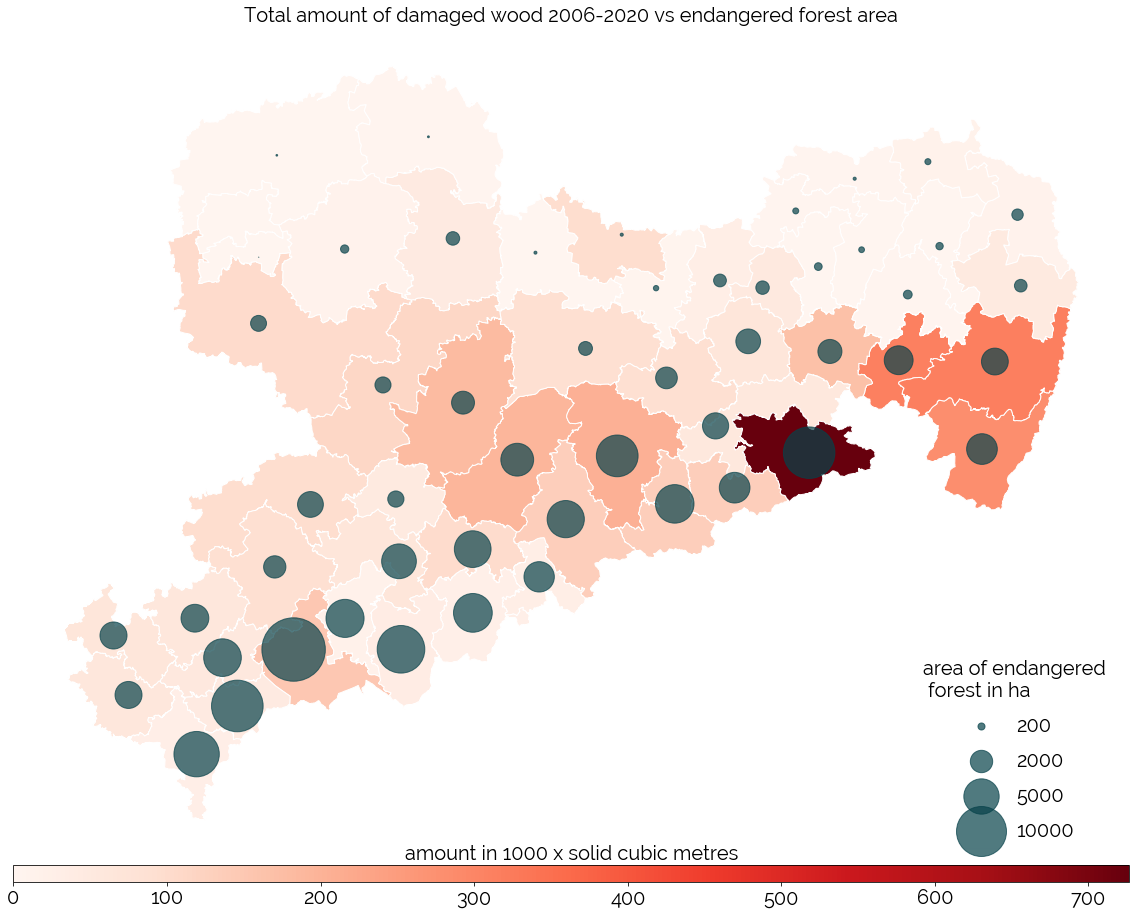

In [145]:
# get the total amount of damaged wood for every forestry district
total_zugang = data.groupby('district_name')['Zugang'].sum()

# read shapefile with geodata since we need it to plot the map
districts_gdf = gpd.read_file(r'data_raw/shape/ufb_rev_wald_teil.shp', encoding='utf-8')

# map information on total amount of damaged wood from dataset to the geodataframe entries
districts_gdf['total_zugang'] = [total_zugang.loc[total_zugang.index == district_name].item()/1000 for district_name in districts_gdf['REVUFB_NM']]

# create column with total amount of endangered forest area (add private and state owned together)
# scale by 0.25 to get the right bubble sizes, later scale the same amount in legend
area_scale = .25
districts_gdf['area_endangered'] = (districts_gdf['NSW_FI'] + districts_gdf['SW_FI']) * area_scale


# create plot
fig, ax = plt.subplots(figsize=(20,20))

# plot title
plt.title('Total amount of damaged wood 2006-2020 vs endangered forest area', fontdict={'fontsize': 20})

# custom legend for colormap requires locateable axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="2%", pad=0.1) # colormap parameters

# plot the forestry districts chloropleth map
districts_gdf.plot(ax=ax, column='total_zugang', legend=True, cax=cax,
          edgecolor='white', linewidth=1, legend_kwds={'orientation': 'horizontal'},
          cmap='Reds')


# colormap legend title and ticks
plt.title('amount in 1000 x solid cubic metres', fontdict={'fontsize': 20})
cax.tick_params(labelsize=20)


#counties_gdf = districts_gdf.dissolve(by='KREIS_NAME')
#counties_gdf.plot(ax=ax, legend=True, color='none',
#                edgecolor='black', linewidth=.5)

# bubble map 
# calculate representative points from polygons (used as bubble location)
gdf_points = districts_gdf.copy()
gdf_points['geometry'] = gdf_points['geometry'].representative_point()
# plot bubbles
gdf_points.plot(ax=ax, color='#07424A', markersize='area_endangered',alpha=.7, categorical=False, legend=True)

# make some dummy points at 0,0 to use as custom legend handles in the bubble plot legend
ax.scatter([0], [0], c='#07424A', alpha=.7, s=200*area_scale,
            label='200')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=2000*area_scale,
            label='2000')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=5000*area_scale,
            label='5000')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=10000*area_scale,
            label='10000')

# add bubble map legend
ax.legend(scatterpoints=1, frameon=True,
        labelspacing=.8, loc='lower right', fontsize=20, edgecolor='white',
        bbox_to_anchor=(1,0), title_fontsize=20, title='area of endangered \n forest in ha');

# x and y axis settings
ax.set_xlim(267100.4013500002, 514160.39804999967);
ax.set_ylim(5552730.938154999, 5736554.970745001);
ax.axis('off');


We can also print out th top and bottom values to supplement the plot:

In [88]:
# first restore the original amount of damaged wood and endangered forest area (revert scale)
districts_gdf['area_endangered'] = districts_gdf['area_endangered']/area_scale
districts_gdf['total_zugang'] = districts_gdf['total_zugang']*1000

# get top and bottom rows regarding amount of damaged wood
district_info = districts_gdf[['KREIS_NAME', 'REVUFB_NM', 'total_zugang', 'area_endangered']].sort_values('total_zugang', ascending=False)
district_info.head(4).append(district_info.tail(4))

,KREIS_NAME,REVUFB_NM,total_zugang,area_endangered
38,Sächsische Schweiz-Osterzgebirge,Sebnitz,7.265892e+11,169788.80
42,Görlitz,Löbau,3.174230e+11,46064.64
20,Bautzen,Cunewalde,3.146773e+11,53314.88
19,Görlitz,Zittau,2.830097e+11,60361.44
10,Sächsische Schweiz-Osterzgebirge,Freital,2.044871e+11,111474.40
0,Mittelsachsen,Reinsberg,1.937191e+11,68856.00
3,Mittelsachsen,Striegistal,1.831053e+11,33619.52
33,Bautzen,Bischofswerda,1.681282e+11,37000.32
7,Erzgebirgskreis,Eibenstock,1.506254e+11,257721.76
52,Mittelsachsen,Frauenstein,1.358694e+11,88674.72


The first thing that catches the eye is the dark red shade of the *Sebnitz* district. The amount of total observed damaged wood far exceeds that of the other forestry districts. Some correlation exists between the amount of damaged wood and the area of endangered forest. However there are also other factors at play. Although the area of endangered forest of the forestry districts of the *Görlitz* county in the east and the *Erzgebirgskreis* in the central south are comparable, *Görlitz* has much higher amounts of damaged wood.

Let's take a closer look at relationship between area of endangered forest and amount of damaged wood. 

In [155]:
newcounty = data['county_name']*(data['Zugang']*100).astype(int)

In [164]:
newdata = data[['county_name','district_name','Eigentumsgruppe', 'Zugang']]

In [165]:
new_df = newdata.loc[newdata.index.repeat((newdata['Zugang']*1).astype(int))]

In [166]:
new_df.shape

(4495810, 4)

In [ ]:
plt.text()

In [181]:
from pysankey2 import Sankey
from pysankey2.utils import setColorConf

s = Sankey(new_df[['county_name','district_name','Eigentumsgruppe']], stripColor='left', colorMode='layer')


In [ ]:
, 'sans-serif':'Raleway'

In [ ]:
fig, ax= s.plot(stripLen=10, figSize=(20,20), boxInterv=.005, fontPos=(0.5,0.5), text_kws={'family':'sans-serif'})

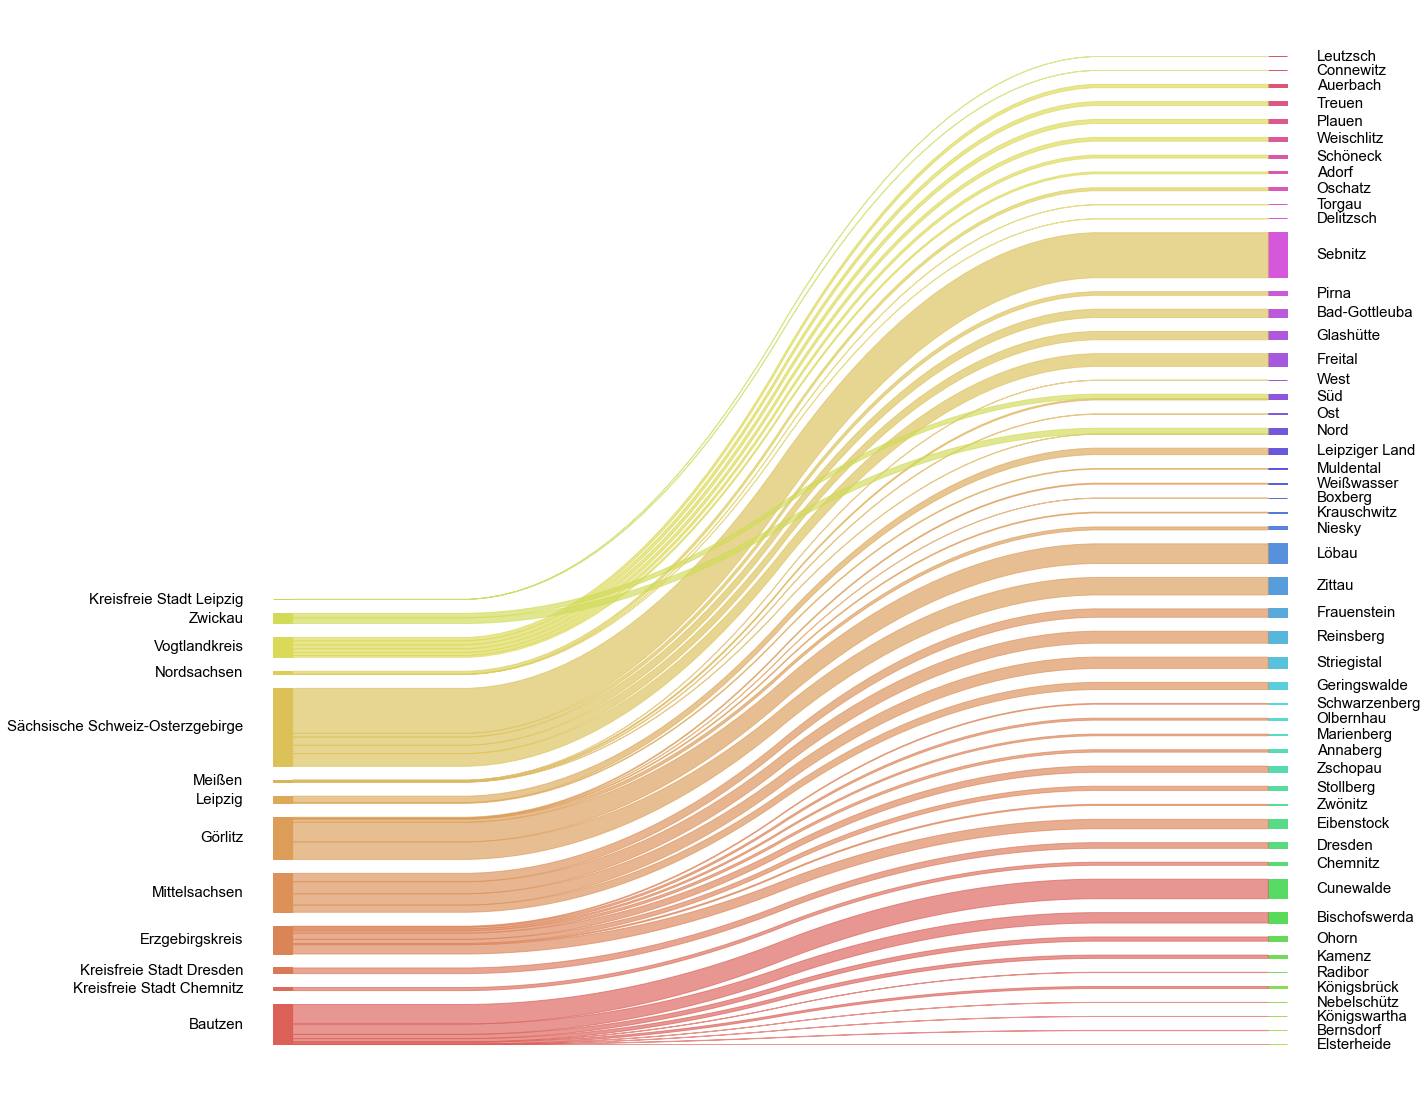

In [148]:
from pySankey import sankey

sankey.sankey(
    left=data['county_name'], right=data['district_name'], leftWeight=data['Zugang'], aspect=10,
    fontsize=15
)
plt.gcf().set_size_inches(20,20)

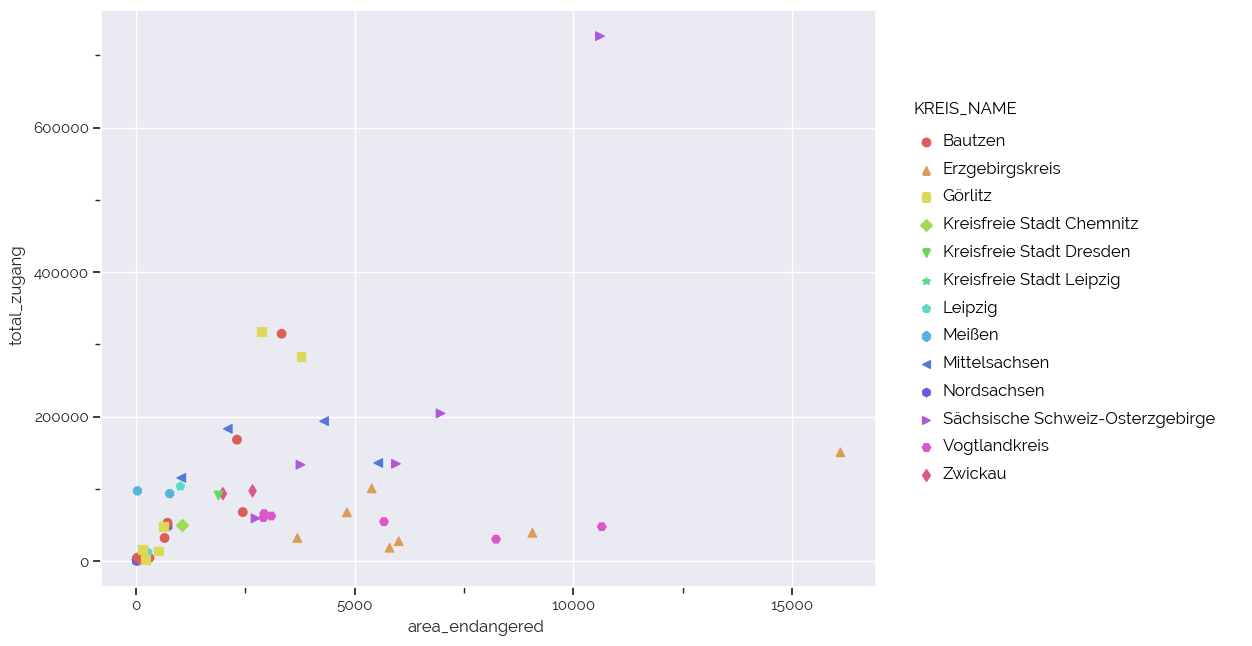

In [85]:
p9.options.figure_size = (10, 7.5)

(
    p9.ggplot(districts_gdf, p9.aes('area_endangered' , 'total_zugang', color='KREIS_NAME')) 
    + p9.geom_point(p9.aes(shape='KREIS_NAME'), size=3)
    + p9.theme_seaborn()
).draw();

In [51]:
x = data.groupby('timestamp')['Zugang'].sum().index
y = data.groupby('timestamp')['Zugang'].sum().values

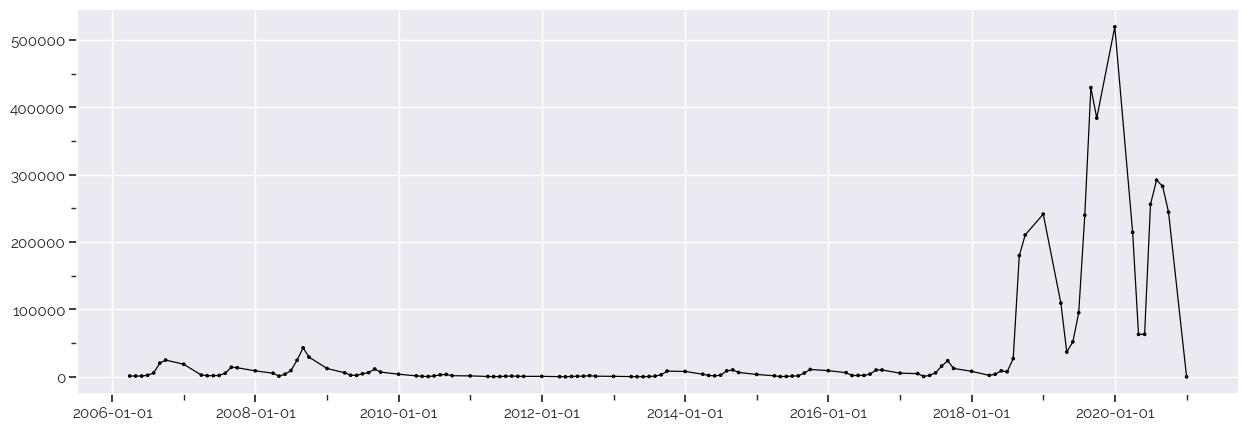

In [56]:
p9.options.figure_size = (15, 5)
(
    p9.ggplot(p9.aes(x,y)) 
    + p9.geom_line()
    + p9.geom_point(size=.5)
    + p9.theme_seaborn()
).draw();

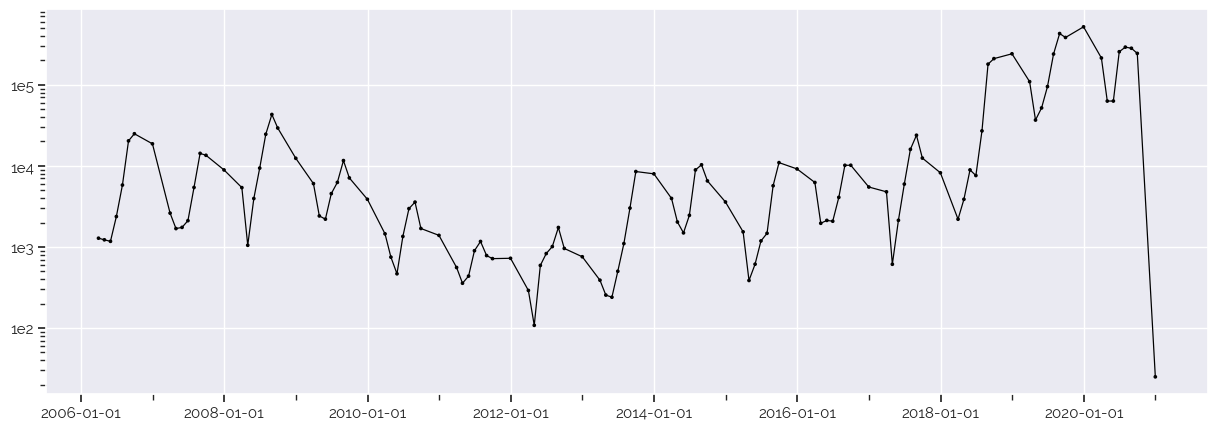

In [57]:
(
    p9.ggplot(p9.aes(x,y)) 
    + p9.geom_line()
    + p9.geom_point(size=.5)
    + p9.scale_y_log10()
    + p9.theme_seaborn()
).draw();

In [59]:
grouped_by_county = data.groupby(['timestamp','county_name'])['Zugang'].sum().reset_index()

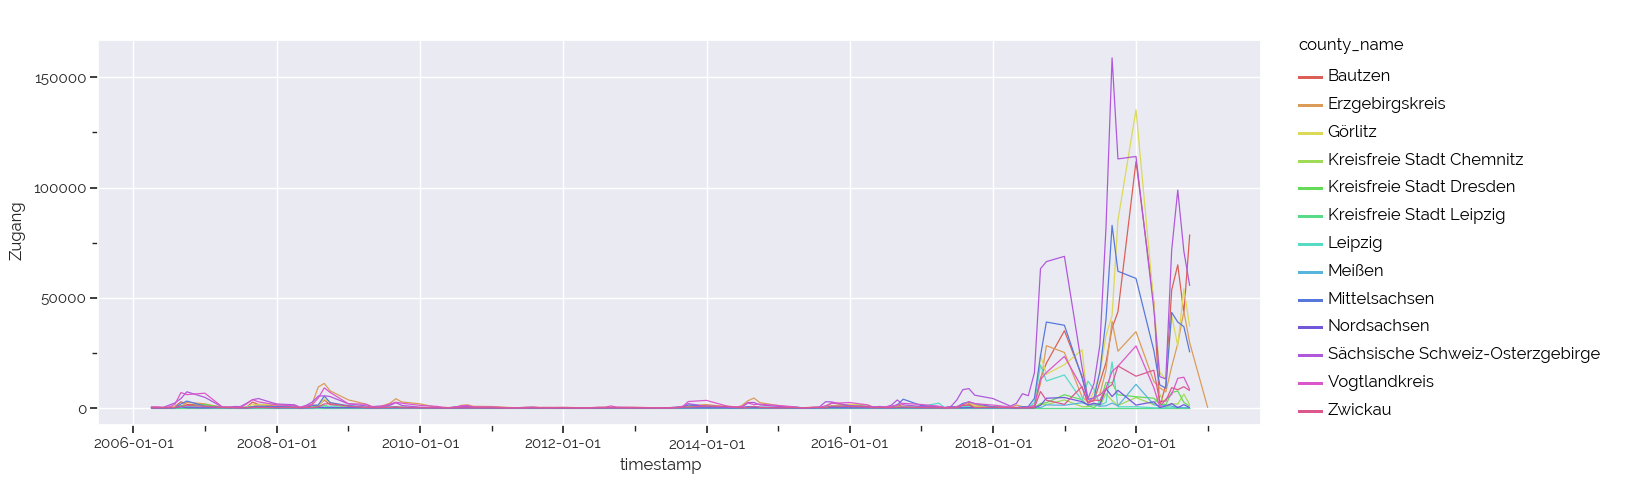

In [60]:
(
    p9.ggplot(grouped_by_county, p9.aes('timestamp', 'Zugang', color='county_name'))
    + p9.geom_line()
    + p9.theme_seaborn()
).draw();

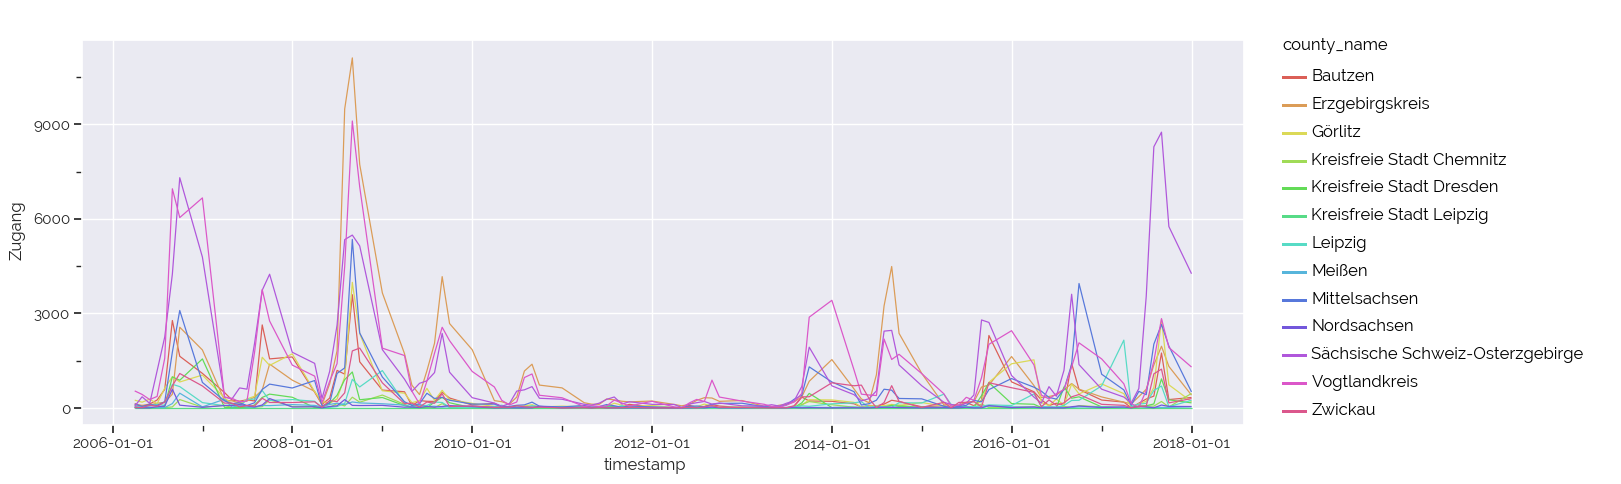

In [62]:
(
    p9.ggplot(grouped_by_county[grouped_by_county['timestamp'] < pd.Timestamp('2018-01-01')], p9.aes('timestamp', 'Zugang', color='county_name')) 
    + p9.geom_line()
    + p9.theme_seaborn()
).draw();

In [171]:
summed_timestamps = data.groupby('timestamp')['Zugang'].sum().index
summed_zugang = data.groupby('timestamp')['Zugang'].sum().values
mean_TM0 = data.groupby('timestamp')['TM0_mean'].mean().values

In [ ]:
(
    p9.ggplot(grouped[grouped['timestamp'] < pd.Timestamp('2018-01-01')], p9.aes('timestamp', 'Zugang', color='county_name')) 
    + p9.geom_line()
    + p9.theme_seaborn()
).draw();

# tsfresh

In [14]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

try:
    import pandas_datareader.data as web
except ImportError:
    print("You need to install the pandas_datareader. Run pip install pandas_datareader.")

from sklearn.ensemble import AdaBoostRegressor

In [15]:
data.columns

Index(['REVUFBADR', 'Jahr', 'ZR', 'Eigentumsgruppe', 'Zugang', 'Abgang',
       'ETP_mean', 'FF1_mean', 'FF2_mean', 'FFB_mean', 'GRV_mean', 'KWK_mean',
       'KWU_mean', 'RF0_mean', 'RGK_mean', 'RRK_mean', 'RRU_mean', 'SD0_mean',
       'TM0_mean', 'TN0_mean', 'TX0_mean', 'area_nse', 'area_nsne', 'area_se',
       'area_sne', 'centroid_xcoord', 'centroid_ycoord', 'county_name',
       'district_name', 'id', 'timestamp'],
      dtype='object')

In [16]:
data_prep = data.drop(['Jahr', 'REVUFBADR', 'county_name', 'district_name', 'ZR', 'Eigentumsgruppe'], axis=1).dropna()

In [17]:
df_rolled = roll_time_series(data_prep, column_id="id", column_sort="timestamp",
                             max_timeshift=24, min_timeshift=3)

C:\Users\Yannic\.conda\envs\python377\lib\site-packages\tsfresh\utilities\dataframe_functions.py:454: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
Rolling: 100%|██████████| 38/38 [00:03<00:00, 12.02it/s]


In [ ]:
X = extract_features(df_rolled, 
                     column_id="id", column_sort="timestamp", 
                     impute_function=impute, show_warnings=False)

Feature Extraction:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
X.to_csv('X.csv')

In [ ]:
X_saved = X

In [ ]:
X = X_saved

In [ ]:
X.shape

In [ ]:
# split up the two parts of the index and give them proper names
X = X.set_index([X.index.map(lambda x: x[0]), X.index.map(lambda x: x[1])], drop=True)
X.index.names = ["id", "last_timestamp"]

In [ ]:
y = data_prep.groupby("id").apply(lambda x: x.set_index("timestamp")["Zugang"].shift(-1)).T
# TODO: Wo kommen NaNs her? --> Wahrscheinlich der eine Bezirk den es nicht mehr gibt nach 2014
# drop 'Erzgebirgskreis-Schwarzenberg-NSW' and 'SW'
y = y[(y.index.get_level_values('id') != 'Erzgebirgskreis-Schwarzenberg-NSW') & (y.index.get_level_values('id') != 'Erzgebirgskreis-Schwarzenberg-SW')]

In [ ]:
y.head()

In [ ]:
# consistrnecy test
y["2006-07-31"] 

data_prep.loc[data_prep['timestamp'] == "2006-08-31"].head(15)





In [ ]:
y = y.dropna()

In [ ]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

In [ ]:
X_train = X.loc[(slice(None), slice(None, "2018")), :]
X_test = X.loc[(slice(None), slice("2019", "2020")), :]

y_train = y.sort_index().loc[(slice(None), slice(None, "2018"))]
y_test = y.sort_index().loc[(slice(None), slice("2019", "2020"))]

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_train_selected = select_features(X_train, y_train)

In [ ]:
adas = {ts_id: AdaBoostRegressor() for ts_id in X.index.get_level_values('id').unique()}

for ts_id, ada in adas.items():
    ada.fit(X_train_selected.loc[ts_id], y_train.loc[ts_id])

In [ ]:
X_test_selected = X_test[X_train_selected.columns]

y_pred = pd.concat({
    ts_id: pd.Series(adas[ts_id].predict(X_test_selected.loc[ts_id]), index=X_test_selected.loc[ts_id].index)
    for ts_id in adas.keys()
})
y_pred.index.names = ["id", "last_timestamp"]

In [ ]:
y.unstack("id").iloc[:,:4]

In [ ]:
plt.figure(figsize=(15, 6))
i = 80
y.unstack("id").iloc[:,i:i+1].plot(ax=plt.gca())
y_pred.unstack("id").iloc[:,i:i+1].plot(ax=plt.gca(), legend=None, marker=".")